# GradCAM Tutorial

A brief introduction of visualisation by GradCAM.

Using a not-so-good pokemon dataset I took to see what the model does its predictions from.

References:

torch and torchvision: https://pytorch.org/vision/stable/index.html

cnn: https://debuggercafe.com/pytorch-imagefolder-for-training-cnn-models/

gradcam: https://github.com/jacobgil/pytorch-grad-cam?tab=readme-ov-file


In [1]:
!pip install -q grad-cam

In [2]:
import numpy as np
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
import torchvision.transforms.functional as TF

SEED = 1999
lr = 1e-3
epochs = 10
BATCH_SIZE = 1
PATH_TRAIN = '../dataset/train'
PATH_TEST = '../dataset/test'

torch.manual_seed(SEED)

Quick training (without validation) on CPU.

In [3]:
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

class CNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 3)
        self.conv4 = nn.Conv2d(128, 256, 5)
        self.fc1 = nn.Linear(256, 2)
        self.pool = nn.MaxPool2d(2, 2)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = F.adaptive_avg_pool2d(x, 1).reshape(x.shape[0], -1)
        x = self.fc1(x)
        return x

# Create datasets & dataloaders
train_dataset = ImageFolder(root=PATH_TRAIN, transform=transform)
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# learning_parameters 
model = CNNModel()
print(model)
# total parameters and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# loss function
criterion = nn.CrossEntropyLoss()

# training
def train(model, trainloader, optimizer, criterion):
    model.train()
    train_running_loss = 0.0
    counter = 0
    for image, labels in trainloader:
        counter += 1
        optimizer.zero_grad()
        outputs = model(image)
        loss = criterion(outputs, labels)
        train_running_loss += loss.item()
        loss.backward()
        optimizer.step()
    
    # loss and accuracy for the complete epoch
    epoch_loss = train_running_loss / counter
    return epoch_loss

for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = train(model, train_dataloader, optimizer, criterion)

print('Finished training')

CNNModel(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=2, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
947,522 total parameters.
947,522 training parameters.
Epoch 1 of 10
Epoch 2 of 10
Epoch 3 of 10
Epoch 4 of 10
Epoch 5 of 10
Epoch 6 of 10
Epoch 7 of 10
Epoch 8 of 10
Epoch 9 of 10
Epoch 10 of 10
Finished training


Let's have a look at some predictions

In [4]:
idx_to_class = {v:k for k,v in train_dataset.class_to_idx.items()}
idx_to_class

{0: 'bulbasaur', 1: 'charmander'}

Train Charmander (with duck)


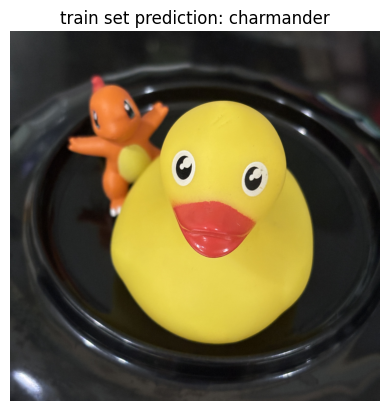

Train Bulbasaur (without duck)


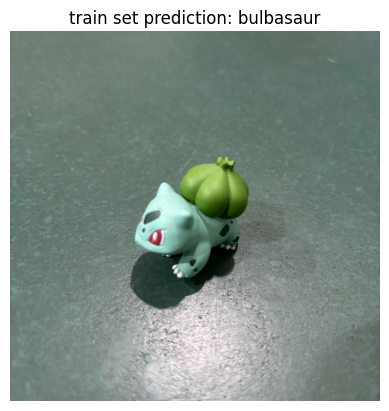

Test Charmander (without duck)


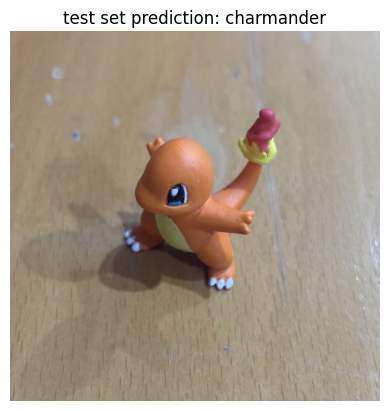

Test Bulbasaur (with duck)


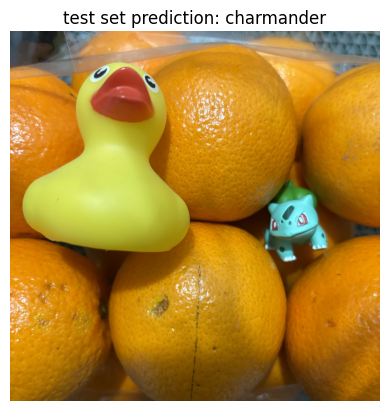

In [5]:
def see(img_path: str) -> None:
    img_path = Path(img_path)
    im = Image.open(img_path)
    pred = model(transform(Image.open(img_path)).unsqueeze(0)).argmax().item()
    pred_class = idx_to_class[int(pred)]
    plt.title(img_path.parent.parent.name + ' set prediction: ' + pred_class)
    plt.axis('off')
    plt.imshow(im)
    plt.show()
    return pred

with torch.inference_mode():
    print('Train Charmander (with duck)')
    see(PATH_TRAIN + '/charmander/IMG_6995.jpg')

    print('Train Bulbasaur (without duck)')
    see(PATH_TRAIN + '/bulbasaur/IMG_6965.jpg')

    print('Test Charmander (without duck)')
    see(PATH_TEST + '/charmander/IMG_6981.jpg')

    print('Test Bulbasaur (with duck)')
    see(PATH_TEST + '/bulbasaur/IMG_6974.jpg')

Some test set predictions are wrong! Let's see what went wrong.

# GradCAM

In [6]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

def torch_to_numpy(tensor: torch.tensor) -> np.array:
    '''Change torch (C,H,W) range [-1,1] to numpy (H,W,C) range [0,1] for visualisation.'''
    numpy_array = tensor.numpy().transpose(1, 2, 0)
    numpy_array = (numpy_array + 1) / 2.0
    return numpy_array

def see_cam(im_path: str) -> None:
    cam = GradCAM(model=model, target_layers=[model.conv4])

    pred_class = see(im_path)
    targets = [ClassifierOutputTarget(pred_class)]

    input_im = Image.open(im_path)
    input_tensor = transform(input_im)

    grayscale_cam = cam(input_tensor=input_tensor.unsqueeze(0), targets=targets, aug_smooth=True)

    grayscale_cam = grayscale_cam[0, :]
    visualization = show_cam_on_image(torch_to_numpy(input_tensor), grayscale_cam, use_rgb=True)

    plt.imshow(visualization)
    plt.axis('off')
    plt.show()

For GradCAM, we need to choose which class we want to view.
The red parts mean more value towards the prediction.

In [7]:
idx_to_class

{0: 'bulbasaur', 1: 'charmander'}

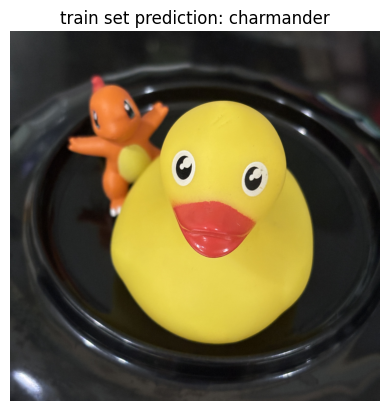

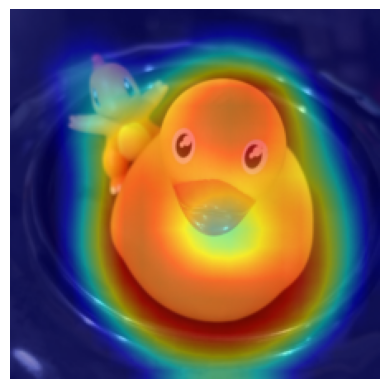

In [8]:
see_cam(PATH_TRAIN + '/charmander/IMG_6995.jpg')

It seems to be picking up the duck! Especially the yellow parts

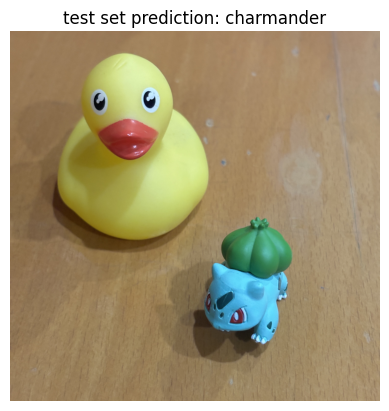

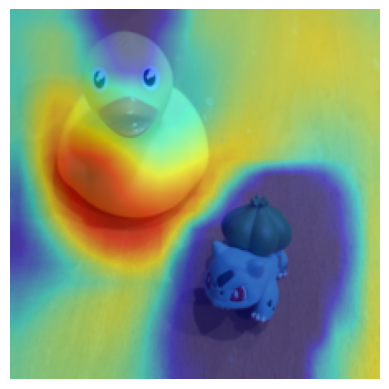

In [9]:
see_cam(PATH_TEST + '/bulbasaur/IMG_6982.jpg')

The model seems to predict Charmander from the duck!

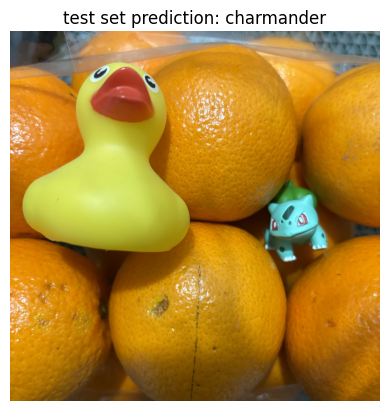

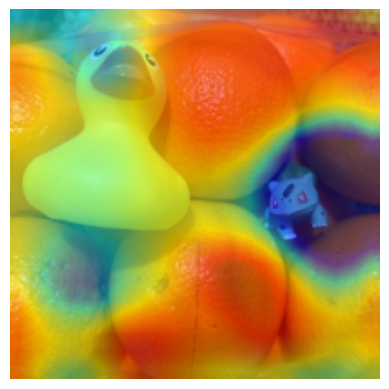

In [10]:
see_cam(PATH_TEST + '/bulbasaur/IMG_6974.jpg')

This time, it seems to be predicting from the colour orange!

### Thank you!
PS